# Coursework 3: document models
_[Original](http://mlg.eng.cam.ac.uk/teaching/4f13/1819/cw/coursework3.pdf) by Carl Rasmussen and Manon Kok for [CUED course 4f13](http://mlg.eng.cam.ac.uk/teaching/4f13/1819/). This version adapted by Damon Wischik._

This coursework involves aggregating, summarizing, and joining datasets. This may be done with straight Python, or with MATLAB-style manipulations using `numpy`, or with `pandas` dataframes. If you anticipate future work in machine learning and data science then you should learn to use `pandas` dataframes, and you may find it helpful to follow the walkthrough in [Section 3](https://notebooks.azure.com/djw1005/libraries/cl-scicomp/html/3.%20Working%20with%20data.ipynb) of IA _Scientific Computing_. If you prefer not to use dataframes, and you have questions about how they are being used in the code snippets below, ask your classmates or Dr Wischik.

**What to submit.**
Your answers should contain an explanation of what you do, and
2&ndash;4 central commands to achieve it. Complete listings are
unnecessary. The focus of your answer should be
_interpretation:_ explain what the numerical values and graphs
you produce _mean,_ and why they are as they are.  The text of
your answer to each question should be no more than a paragraph or
two.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.io
import pandas

import requests, io

## Data import

The data is provided as `http://mlg.eng.cam.ac.uk/teaching/4f13/1112/cw/kos_doc_data.mat`. It contains two matrices $A$ and $B$ for training and testing respectively, both matrices with 3 columns: document ID, word ID, and word count. The words themselves are the vector $V$, where e.g. `V[840]='bush'`. The following snippet reads in the data, and converts $A$ and $B$ to dataframes.

In [2]:
r = requests.get('http://mlg.eng.cam.ac.uk/teaching/4f13/1112/cw/kos_doc_data.mat')
with io.BytesIO(r.content) as f:
    data = scipy.io.loadmat(f)
    V = np.array([i[0] for i in data['V'].squeeze()])
    A,B = [pandas.DataFrame({'doc_id': M[:,0]-1, 'word_id': M[:,1]-1, 'count': M[:,2]}, 
                            columns=['doc_id','word_id','count']) 
           for M in (data['A'],data['B'])]

## Question (a): simple categorical model

Suppose we model words in a document as independent samples from a categorical distribution with parameter $\beta$, where $\beta_v$ is the probability of word $v\in V$. Using $A$ as the training set, find the maximum likelihood estimator $\hat{\beta}$, and plot the 20 most-probable words in a histogram. What is the log probability of the test document `doc_id=2527`, given $\hat{\beta}$? Briefly interpret your answer.

Note: you can plot a histogram with
```
with plt.rc_context({'figure.figsize': (5,8)}):            # set plot size
    plt.barh(np.arange(20), top_20_probs, align='center')  # draw bars
plt.yticks(np.arange(20), top_20_words)                    # label the y axis
plt.xlabel(r'$\hat{\beta}$')                               # label the x axis
plt.gca().invert_yaxis()                                   # optionally, flip the y-axis
plt.show()
```

\begin{align*}
p(c_1,...,c_k|\boldsymbol{\beta}) &= \text{Mult}(c_i,...,c_k|\beta_1,...,\beta_k)\\
\hat \beta &= \argmax_\beta  \log p(c_1,...,c_k|\boldsymbol{\beta}) = \argmax_\beta \sum_{i=1}^k c_i\log(\beta_i) + \lambda(1-\sum_{i=1}^k \beta_i)\\
\frac{\partial \log p(c_1,...,c_k|\boldsymbol{\beta})}{\partial\beta_i} &= \frac{c_i}{\beta_i}-\lambda =0\implies \beta_i=\frac{c_i}{\lambda}\\
\frac{\partial \log p(c_1,...,c_k|\boldsymbol{\beta})}{\partial\lambda} &\implies \sum_{i=1}^k \beta_i = 1\\
\sum\beta_i = 1 &= \sum \frac{c_i}{\lambda} = 1 \implies \sum c_i = \lambda = \text{total number of words} = n \\ 
&\implies \hat\beta_i = \frac{c_i}n
\end{align*}
where $k=|V|$

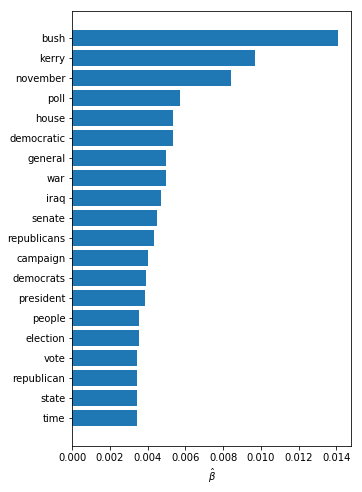

In [3]:
c = A.groupby('word_id').sum()[['count']]
n = int(c.sum())
β_hat = c/n
β_hat.columns = ['prob']
β_sorted = β_hat.sort_values('prob', ascending=False)
top_20_probs = β_sorted.values.squeeze()[:20]
top_20_words = V[β_sorted.index][:20]
ranked_words = V[β_sorted.index]

with plt.rc_context({'figure.figsize': (5,8)}):            # set plot size
    plt.barh(np.arange(20), top_20_probs, align='center')  # draw bars
plt.yticks(np.arange(20), top_20_words)                    # label the y axis
plt.xlabel(r'$\hat{\beta}$')                               # label the x axis
plt.gca().invert_yaxis()
plt.show()

\begin{align*}
p(\text{doc}|\boldsymbol{\beta}) &= \prod_{w\in \text{doc}} \beta_w \\
\log p(\text{doc}|\boldsymbol{\beta}) &= \sum_{w\in \text{doc}} \log \beta_w
\end{align*}

In [4]:
def calculate_log_doc_prob(doc_id, data, β, fill=0, func=np.log):
    doc = data.loc[data['doc_id'] == doc_id]
    doc_joined = doc.join(β, on='word_id').fillna(fill)
    doc_joined['logprob'] = doc_joined.apply(lambda row: row['count'] * func(row['prob']), axis=1)
    return doc_joined.sum()[4]

doc_id = 2527
log_doc_prob = calculate_log_doc_prob(doc_id, B, β_hat)
print(log_doc_prob)

-inf


c:\users\cobmo\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


If we encounter a word that has not been seen before, then we get an infinitely zero probability of that word occurring. When the log is taken it results in a negative infinity. Thus, when the document probability is calculated by summing the log-probabilities, $-\infty$ is added and so the final result will be $-\infty$

## Question (b): Bayesian inference

For the categorical model in part (a), use Bayesian inference to find the posterior distribution of $\beta$ given the training set $A$, using a symmetric Dirichlet distribution with concentration parameter $\alpha=0.1$ as prior. Let $\tilde{\beta}_v$ be the posterior predictive probability of word $v\in V$, i.e. the posterior probability that a newly chosen word is $v$. Derive an expression for $\tilde{\beta}_v$, and compare it to $\hat{\beta}_v$. Explain the implications, both for common and for rare words.

Hint: $\Gamma(z+1)=z\,\Gamma(z)$.

Let $p(\boldsymbol{\beta}) \sim \text{Dir}(\alpha)$ where $\alpha=0.1$
\begin{align*}
p(\boldsymbol{\beta}|\mathbf{c}) &\propto p(\mathbf{c}|\boldsymbol{\beta})p(\boldsymbol{\beta})\\
&\propto \prod_i \beta_i^{c_i} \cdot \prod_i \beta_i^{\alpha-1} = \prod_i \beta_i^{c_i+\alpha-1}\\
&\implies \boldsymbol{\beta}|\mathbf{c} \sim \text{Dir}(\mathbf{c}+\alpha)
\end{align*}


\begin{align*}
\tilde\beta_v = p(v|A)  &= \int p(v|\boldsymbol{\beta})p(\boldsymbol{\beta}|\mathbf{c}) \:d\boldsymbol{\beta} \\
&= \int\frac{\Gamma(\sum_{i=1} c_i+ \alpha)}{\prod_{i=1}\Gamma(c_i+\alpha)}\prod_{i=1,i\neq v} \beta_i^{c_i+\alpha-1}\cdot\beta_v^{c_v+\alpha+1-1} \:d\boldsymbol{\beta}\\
&= \frac{\Gamma(\sum_{i=1} c_i+ \alpha)}{\Gamma(\sum_{i=1} c_i+ \alpha+1)}\frac{\Gamma(c_v+\alpha+1)}{\Gamma(c_v+ \alpha)}\int\frac{\Gamma(\sum_{i=1} c_i+ \alpha)}{\prod_{i=1}\Gamma(c_i+\alpha)}\prod_{i=1,i\neq v} \beta_i^{c_i+\alpha-1}\cdot\beta_v^{c_v+\alpha+1-1} \:d\boldsymbol{\beta}\\
&= \frac{\Gamma(\sum_{i=1} c_i+ \alpha)}{\Gamma(\sum_{i=1} c_i+ \alpha+1)}\frac{\Gamma(c_v+\alpha+1)}{\Gamma(c_v+ \alpha)} = \frac{\Gamma(\sum_{i=1} c_i+ \alpha)}{\sum_{i=1} (c_i+ \alpha)\Gamma(\sum_{i=1} c_i+ \alpha)}\frac{(c_v+\alpha)\Gamma(c_v+\alpha)}{\Gamma(c_v+ \alpha)} \\
&= \frac{1}{\sum_{i=1} (c_i+ \alpha)}\frac{(c_v+\alpha)}{1} = \frac{(c_v+\alpha)}{\sum_{i=1} (c_i+ \alpha)}
\end{align*}

In [5]:
α = 0.1
c = A.groupby('word_id').sum()[['count']]
β = (c+α) / (c.sum() + c.shape[0]*α)
β.columns = ['prob']

doc_id = 2527
log_doc_prob = calculate_log_doc_prob(doc_id, B, β, fill=0.1)

print('log probability of document 2527:', log_doc_prob)

log probability of document 2527: -1463.5761999698352


The alpha adds pseudocounts to every word, so that it smooths the maximum likelihood; unseen words have non-zero likelihood, rarer words have a higher likelihood and thus more common words have slighly lower probabilities (to maintain normalisation to 1). As seen, this means that documents with unseen words have non-infinity probabilities.

## Question (c): interpretation

In information theory, the _self-information_ of a document $w$ is defined as $i(w) = -\log_2 p(w)$, where $p(\cdot)$ is the probability mass function for the document generating model that you have fitted. The self-information can be interpreted as the number of bits needed to encode or transmit $w$. The number of bits needed per word is thus $i(w)/n$. In text modelling, it is more common to use the terms _perplexity_ for $2^{i(w)}$, and _per-word perplexity_ for $2^{i(w)/n}$. Loosely speaking, if the per-word perplexity is $g$ then the uncertainty in the next word is the same as the uncertainty in a $g$-sided die.

For the trained Bayesian model from part (b), what is the per-word perplexity of the test document `doc_id=2000`? Plot a histogram showing the distribution of per-word perplexity over all the test documents (using [`plt.hist`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html?highlight=matplotlib%20pyplot%20hist#matplotlib.pyplot.hist)). Pick out two documents, one with high per-word perplexity and one with low per-word perplexity, show their contents, and interpret the difference between them.

In [6]:
def calculate_perplexity(countsum, log_doc_prob):
    i_w = -log_doc_prob
    return 2**(i_w/countsum.sum())

doc_id = 2000
doc = B.loc[B['doc_id'] == doc_id]
log_doc_prob = calculate_log_doc_prob(doc_id, B, β, fill=0.1, func=np.log2)
print(log_doc_prob)
perp = calculate_perplexity(doc['count'].sum(), log_doc_prob)
print('Per-word perplexity:', perp)

-5325.296896400677
Per-word perplexity: 4398.962208666455


In [7]:
doc_joined = B.join(β, on='word_id').fillna(0.1)

doc_joined['logprob'] = doc_joined.apply(lambda row: row['count'] * np.log2(row['prob']), axis=1)

a = doc_joined.groupby('doc_id').sum()
a['perp'] = a.apply(lambda row: calculate_perplexity(row['count'], row['logprob']), axis=1)
perps = a[['perp']].values.squeeze()

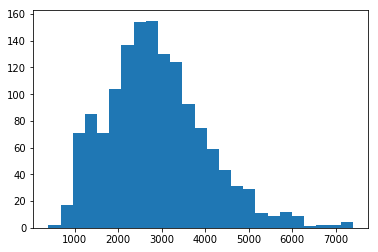

In [8]:
plt.hist(perps, bins=25)
print()

Per-word perplexity: 399.2505850134762
['administration' 'american' 'arg' 'bush' 'democrats' 'february' 'general'
 'group' 'independents' 'intelligence' 'kerry' 'latest' 'mar' 'national'
 'poll' 'republicans' 'research' 'results' 'wont']

Per-word perplexity: 7395.449395602347
['affiliate' 'apology' 'april' 'berkeley' 'bush' 'conventional' 'doom'
 'edition' 'explanation' 'fat' 'forces' 'forgotten' 'garofalo' 'gave'
 'gop' 'greeted' 'ill' 'janeane' 'legal' 'local' 'media' 'newsweek' 'owes'
 'pleasure' 'predicted' 'promised' 'red' 'section' 'strike' 'troops'
 'waiting' 'wife' 'wisdom' 'youre']



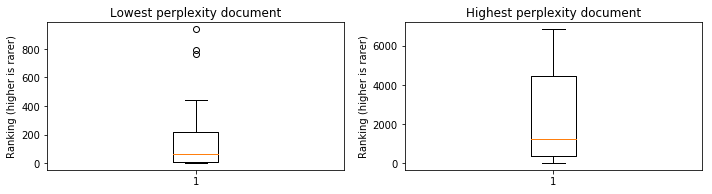

In [9]:
a_sorted = a.sort_values('perp')
min_perp = a_sorted.iloc[0]
max_perp = a_sorted.iloc[-1]
min_perp_doc_id = min_perp.name
max_perp_doc_id = max_perp.name

min_doc = B[B['doc_id'] == min_perp_doc_id]
print('Per-word perplexity:', min_perp['perp'])
print(V[min_doc['word_id']])

plt.figure(figsize=(10,5))
plt.subplot(2, 2, 1)
plt.title('Lowest perplexity document')
plt.ylabel('Ranking (higher is rarer)')
min_bp = list()
for word in V[min_doc['word_id']]:
    min_bp.append(np.where(ranked_words==word)[0][0])
plt.boxplot(min_bp)
print()
max_doc = B[B['doc_id'] == max_perp_doc_id]
print('Per-word perplexity:', max_perp['perp'])
print(V[max_doc['word_id']])

plt.subplot(2, 2, 2)
plt.title('Highest perplexity document')
plt.ylabel('Ranking (higher is rarer)')
max_bp = list()
for word in V[max_doc['word_id']]:
    max_bp.append(np.where(ranked_words==word)[0][0])
    
plt.boxplot(max_bp)
plt.tight_layout()
print()

A lower perplexity indicates that the model is more certain about a prediction; i.e. lower is better. The lowest perplexity document is 399 per word. This means that the model is as uncertain on the sample as it would be if it were made to choose randomly on a 399-side dice for each word. The same goes for the highest perplexity document, with perplexity 7395 per word.

For the lowest perplexity document, as can be seen above the words are all fairly common, for example 'bush', 'kerry' are the most commonly occurring words. Thus the model is not surprised by this document. 

On the other hand, for the highest perplexity document, there are many rare words, meaning the perplexity will be high because the model is less certain. This can be seen in the box plots above, where the rank in the frequency table of all words (defined in question (a)), for all the words in the document are displayed. The higher perplexity document clearly has a much more spread out and rarer selection of words than the lower perplexity document.

## Question (d): Gibbs sampler for the mixture-of-multinomials model

The Bayesian mixture-of-multinomials model can be described by the following code:

In [6]:
def bmm_generate(doc_length, V, α, γ, K):
    # doc_length = [num words in doc1, num words in doc2, ...]
    θ = np.random.dirichlet(α * np.ones(K))              # prob dist over document classes {1,...,K}
    β = np.random.dirichlet(γ * np.ones(len(V)), size=K) # for each doc class, a prob dist over words
    z = np.random.choice(K, p=θ, size=len(doc_length))   # doc class of each document
    return [np.random.choice(V, p=β[zd], size=nd) for zd,nd in zip(z, doc_length)]

for doc in bmm_generate(doc_length=[5,2,4], V=V, α=10, γ=.1, K=20):
    print(doc)

['destroy' 'accusations' 'frist' 'samarra' 'unnecessary']
['layoffs' 'online']
['released' 'listened' 'loss' 'mcgreevey']


The following code implements a collapsed Gibbs sampler. Complete the line that defines `logp`. In each sweep, the Gibbs sampler produces a sample of document classes, and this sample induces a posterior predictive distribution for the probability of each class. Plot how this distribution evolves as a function of the number of Gibbs sweeps. How many iterations does it take to converge?
```
```
The Gibbs sampler may be run as follows:

In [99]:
def bmm_gibbs(doc_label, word_id, count, W, α, γ, K):
    # doc_labels = distinct values of doc_label
    # doc_index = a list as long as doc_label
    #             such that doc_labels[doc_index[j]] = doc_label[j]
    doc_labels, doc_index = np.unique(doc_label, return_inverse=True)

    # z[i] = class of document i, where i enumerates the distinct doc_labels
    # doc_count[k] = number of documents of class k
    z = np.random.choice(K, len(doc_labels))
    doc_count = np.zeros(K, dtype=int)
    for k in z: doc_count[k] += 1

    # occurrences[k,w] = number of occurrences of word_id w in documents of class k
    # word_count[k] = total number of words in documents of class k
    x = pandas.DataFrame({'doc_class': z[doc_index], 'word_id': word_id, 'count': count}) \
        .groupby(['doc_class', 'word_id']) \
        ['count'].apply(sum) \
        .unstack(fill_value=0)
    occurrences = np.zeros((K, len(V)))
    occurrences[x.index.values.reshape((-1,1)), x.columns.values] = x
    word_count = np.sum(occurrences, axis=1)
    
    while True:
        for i in range(len(doc_labels)):

            # get the words,counts for document i
            # and remove this document from the counts
            w,c = word_id[doc_index==i].values, count[doc_index==i].values
            occurrences[z[i], w] -= c
            word_count[z[i]] -= sum(c)
            doc_count[z[i]] -= 1

            # Find the log probability that this document belongs to class k, marginalized over θ and β
            #logp = [... for k in range(K)]
            logp = [(np.log(α+doc_count[k]) + 
                     np.dot(np.log(occurrences[k,w]+γ) - np.log(word_count[k]+γ*W), 
                            c.T)
                    ) for k in range(K)]
            p = np.exp(logp - np.max(logp))
            p = p/sum(p)

            # Assign this document to a new class, chosen randomly, and add back the counts
            k = np.random.choice(K, p=p)
            z[i] = k
            occurrences[k, w] += c
            word_count[k] += sum(c)
            doc_count[k] += 1
        
        yield np.copy(z), doc_count, occurrences, word_count


In [105]:
g = bmm_gibbs(A['doc_id'], A['word_id'], A['count'], W=len(V), α=10, γ=.1, K=20)
NUM_ITERATIONS = 20
res = np.stack([next(g) for _ in range(NUM_ITERATIONS)])
# this produces a matrix with one row per iteration and a column for each unique doc_id

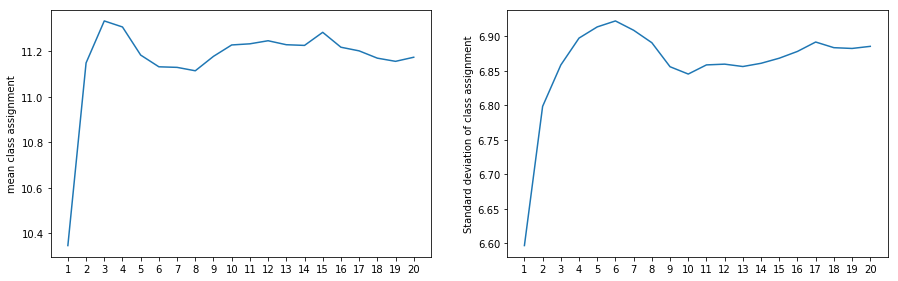

In [106]:
assignments = None
for i in range(20):
    if assignments is None:
        assignments = res[i][0]
    else:
        assignments = np.c_[assignments, res[i][0]]
        
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.plot(range(1,21), np.mean(assignments.T, axis=1))
plt.ylabel('mean class assignment')
plt.xticks(range(1,21))

plt.subplot(2,2,2)
plt.plot(range(1,21), np.std(np.mean(assignments.T, axis=1), axis=1))
plt.xticks(range(1,21))
plt.ylabel('Standard deviation of class assignment')
print()

When the class assignments settle to a constant mean and standard deviation, it suggests that Gibbs sampling has converged.

## Question (e): interpretation

Let $\alpha=10$, $\gamma=0.1$, $K=20$. Run the Gibbs sampler until it converges, and find the posterior predictive probabilities for topics, and for words within each topic. 
For each the 8 most popular topics, print the probability of the topic and the 8 most probable words and their probabilities.
Display probabilities in _shannons_, i.e. display a probability $p$ as $-\log_2 p$. An increase of 1 shannon corresponds to a 50% decrease in probability.

Rerun with different random seeds. Do you think this method has succeeded in identifying topics?

**Optional.** There are some words that are very common across all topics. How might we pick out the _distinctive_ words for each topic?

In [110]:
occurrences = res[-1][2]
doc_count = res[-1][1]
proportions = doc_count/sum(doc_count)

sorted_topics = np.argsort(-proportions)
for topic in sorted_topics:
    indices = np.argsort(-occurrences[topic,:], axis=0).astype(np.int32)[:8]
    top_8_words = V[indices]
    top_8_probs = -np.log2(occurrences[topic, indices]/sum(occurrences[topic,:]))
    print(f'Topic {topic}, proportion {proportions[topic]}')
    display(pandas.DataFrame(np.array([top_8_words, top_8_probs]).T, columns=['Word', 'Shannons']))
    print()


Topic 12, proportion 0.363


,Word,Shannons
0,bush,5.8355443896768096
1,iraq,7.016385168598306
2,war,7.0722384033318235
3,kerry,7.324681397897901
4,president,7.349772378860732
5,administration,7.5283518456135825
6,people,7.690809296695799
7,general,7.948607054163446



Topic 3, proportion 0.1255


,Word,Shannons
0,senate,6.282838945980267
1,house,6.476541330705706
2,race,6.5282254859946365
3,republican,6.642241746286293
4,democrats,6.912889336229962
5,elections,6.953531320727308
6,democratic,6.953531320727308
7,state,7.069990297314691



Topic 14, proportion 0.098


,Word,Shannons
0,bush,4.665571340364949
1,kerry,4.948210304138255
2,poll,5.880900369178828
3,percent,6.364684035532617
4,voters,6.399589650480818
5,general,6.541811723133283
6,polls,6.670891672298213
7,states,7.146403030603372



Topic 6, proportion 0.0965


,Word,Shannons
0,dean,5.054630262746755
1,kerry,5.158113120814333
2,edwards,5.655446714668749
3,primary,5.793348828016712
4,clark,5.916887862426875
5,democratic,5.990385675076266
6,poll,6.272649552390113
7,gephardt,6.303543560335896



Topic 10, proportion 0.0725


,Word,Shannons
0,campaign,6.401008123864895
1,party,6.460203916372795
2,democratic,6.69778274152392
3,dean,6.939600661448018
4,bush,6.939600661448018
5,million,7.0489480576363786
6,democrats,7.130742148800026
7,kerry,7.142814981100601



Topic 9, proportion 0.0515


,Word,Shannons
0,november,4.557556343380504
1,bush,6.34655006256747
2,kerry,6.464789174796793
3,voting,6.5223998979668885
4,house,6.616221920323409
5,republicans,6.686326158787757
6,poll,6.686326158787757
7,senate,6.71047224611946



Topic 0, proportion 0.0455


,Word,Shannons
0,november,4.487755959215611
1,poll,6.377395511773106
2,house,6.518258047612955
3,senate,6.681263635115476
4,republicans,6.730411284444565
5,polls,6.744766577421634
6,bush,6.796165729928279
7,governor,6.818767158865412



Topic 15, proportion 0.035


,Word,Shannons
0,iraq,5.447654450860943
1,war,6.25061760380139
2,iraqi,6.447654450860943
3,american,6.980778020062481
4,bush,7.015129524853259
5,baghdad,7.34577483684173
6,military,7.412889032700267
7,forces,7.459431618637297



Topic 4, proportion 0.025


,Word,Shannons
0,nader,5.820178962415188
1,republican,6.121834662276289
2,ballot,6.173059985631462
3,party,6.262697198116139
4,general,6.3781744155360744
5,voters,6.525731603949932
6,election,6.525731603949932
7,state,6.593903106591512



Topic 7, proportion 0.019


,Word,Shannons
0,ryan,6.589630341763999
1,edwards,6.655218683391576
2,campaign,6.72393143347559
3,john,6.759555343206311
4,kerry,6.833555924650088
5,republican,7.174592842485155
6,news,7.274128516036069
7,senate,7.274128516036069



Topic 13, proportion 0.0165


,Word,Shannons
0,server,6.496654082593496
1,time,6.648657176038546
2,kerry,6.91169158187234
3,elections,6.91169158187234
4,community,6.91169158187234
5,oct,7.011227255423254
6,dkos,7.011227255423254
7,ive,7.011227255423254



Topic 1, proportion 0.0115


,Word,Shannons
0,investigation,6.477206320365274
1,bush,6.766712937560258
2,administration,6.821160721582634
3,federal,6.821160721582634
4,house,7.06216882108643
5,libby,7.06216882108643
6,grand,7.129283016944966
7,time,7.199672344836364



Topic 11, proportion 0.008


,Word,Shannons
0,bush,4.347812254269585
1,kerry,4.65120439771952
2,general,5.74636163075986
3,endorsement,5.813475826618397
4,oct,5.957865735953572
5,papers,6.505353531256065
6,newspaper,6.74636163075986
7,news,6.883865154509795



Topic 19, proportion 0.008


,Word,Shannons
0,bunning,4.566894207959841
1,debate,5.746217907404403
2,mongiardo,5.833680748654742
3,gotv,5.926790153046223
4,senate,6.078793246491274
5,campaign,6.078793246491274
6,kentucky,6.189824558880018
7,senator,6.310118792597729



Topic 16, proportion 0.007


,Word,Shannons
0,bush,5.146841388329271
1,administration,5.575684687133145
2,rice,6.369233809665719
3,intelligence,6.369233809665719
4,commission,6.468769483216634
5,attacks,6.632268215499513
6,information,6.81669278663694
7,president,6.954196310386875



Topic 8, proportion 0.006


,Word,Shannons
0,kerry,4.92283213947754
1,swift,5.844829627476267
2,bush,6.005294299669513
3,boat,6.092757140919852
4,thurlow,6.092757140919852
5,campaign,6.092757140919852
6,star,6.285402218862249
7,kerrys,6.392317422778761



Topic 17, proportion 0.0035


,Word,Shannons
0,november,5.354307387897479
1,general,6.514772060090725
2,iraq,6.744253906213492
3,fallujah,6.901795183199972
4,war,7.017272400619908
5,petraeus,7.142803282703767
6,iraqi,7.2803068064537015
7,military,7.432309899898752



Topic 5, proportion 0.0035


,Word,Shannons
0,court,5.373300196608388
1,scalia,5.447300778052165
2,state,5.525303290053438
3,marriage,5.607765450245411
4,judge,6.110265790774594
5,january,6.235796672858453
6,law,6.235796672858453
7,gay,6.525303290053438



Topic 18, proportion 0.0025


,Word,Shannons
0,book,4.754887502163468
1,reviews,5.6293566200796095
2,seat,5.892391025913404
3,bumpersticker,5.892391025913404
4,senate,6.2143191208007655
5,media,6.2143191208007655
6,amazon,6.2143191208007655
7,carolina,6.6293566200796095



Topic 2, proportion 0.002


,Word,Shannons
0,oceana,5.475733430966398
1,court,5.823656734386705
2,clerks,5.823656734386705
3,fishing,6.113163351581689
4,sharks,6.283088353024002
5,bush,6.283088353024002
6,law,6.283088353024002
7,myers,6.475733430966398


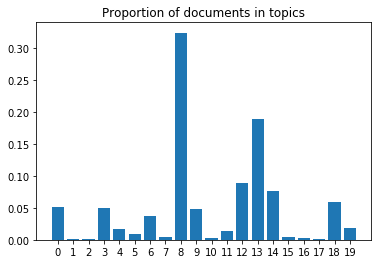

In [96]:
plt.bar(np.arange(20), proportions)
plt.xticks(range(20))
plt.title('Proportion of documents in topics')
print()

Next we run the Gibbs sampler at different random seeds:


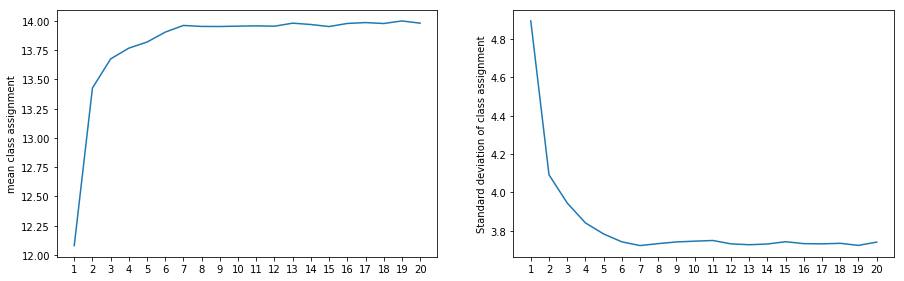

In [76]:
np.random.seed(42)
g = bmm_gibbs(A['doc_id'], A['word_id'], A['count'], W=len(V), α=10, γ=.1, K=20)
NUM_ITERATIONS = 20
res = np.stack([next(g) for _ in range(NUM_ITERATIONS)])

assignments = None
for i in range(20):
    if assignments is None:
        assignments = res[i][0]
    else:
        assignments = np.c_[assignments, res[i][0]]
        
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.plot(range(1,21), np.mean(assignments.T, axis=1))
plt.ylabel('mean class assignment')
plt.xticks(range(1,21))

plt.subplot(2,2,2)
plt.plot(range(1,21), np.std(assignments.T, axis=1))
plt.xticks(range(1,21))
plt.ylabel('Standard deviation of class assignment')
print()

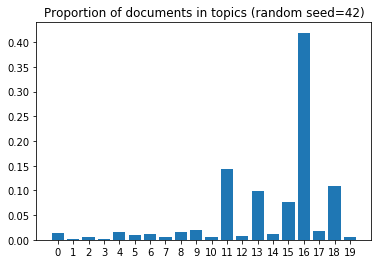

In [80]:
doc_count = res[-1][1]
plt.bar(np.arange(20), doc_count/sum(doc_count))
plt.xticks(range(20))
plt.title('Proportion of documents in topics (random seed=42)')
print()

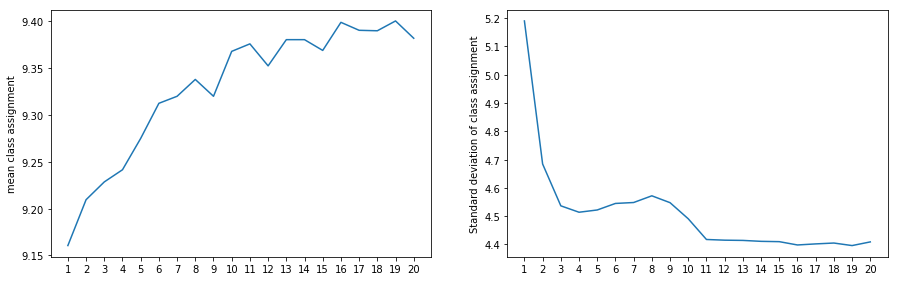

In [108]:
np.random.seed(24)
g = bmm_gibbs(A['doc_id'], A['word_id'], A['count'], W=len(V), α=10, γ=.1, K=20)
NUM_ITERATIONS = 20
res = np.stack([next(g) for _ in range(NUM_ITERATIONS)])

assignments = None
for i in range(20):
    if assignments is None:
        assignments = res[i][0]
    else:
        assignments = np.c_[assignments, res[i][0]]
        
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.plot(range(1,21), np.mean(assignments.T, axis=1))
plt.ylabel('mean class assignment')
plt.xticks(range(1,21))

plt.subplot(2,2,2)
plt.plot(range(1,21), np.std(assignments.T, axis=1))
plt.xticks(range(1,21))
plt.ylabel('Standard deviation of class assignment')
print()

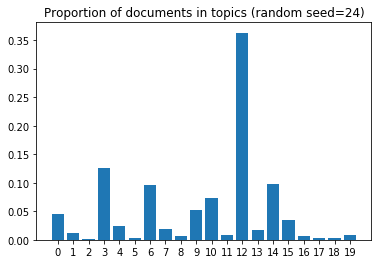

In [109]:
doc_count = res[-1][1]
plt.bar(np.arange(20), doc_count/sum(doc_count))
plt.xticks(range(20))
plt.title('Proportion of documents in topics (random seed=24)')
print()

This suggests that the final predictive posterior very much depends on where the Gibbs sampling starts. With random seed 42 the assignments are heavily weighted with more than 40\% of documents in topic 16.

## Question (f): evaluation

**Optional.** Give a formula for per-word perplexity for the mixture model, in terms of the posterior predictive probabilities for topics and words.

**Optional.** Plot a histogram showing the distribution of per-word perplexity over all the test documents for the model in part (e). Also plot the histogram obtained from $K=8$, and the histogram from the plain multinomial model in part (c). Which model do you prefer, and why?